In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from glob import glob
import SimpleITK as sitk
import tensorflow as tf
from tensorflow import keras
from keras.layers import AveragePooling3D
import time
import copy
from sklearn.cluster import KMeans
import pandas as pd
import gc
from sklearn.linear_model import LinearRegression
import math
import tensorflow as tf
from multiprocessing import Process, Manager
import datetime
import sys
import csv
import os
from tensorflow.keras.utils import to_categorical
from data_generate import *  # 参数生成文件
from KEM_SIMU import *  # KEM 类
sys.path.append('../')
sys.path.append('../Models/')
from utils import *
from GMM import *
from Kmeans import *


%matplotlib inline

In [2]:
# set the working GPU
num_gpu = 1
gpu_name = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_name}"

In [3]:
K = 3       # the number of classes
depth = 99  # present the [depth] image in a cubic
index = 0   # tour the index th CT data: index = 0

lung_image_path = "/database/datasets/Classics/LUNA2016/IMAGES/"  # a folder of CT data
lung_mask_path = "/database/datasets/Classics/LUNA16-Mask/"       # a folder of lung masks
lung_image_file_list = glob(lung_image_path + "*.mhd")            # the absolute paths of the CT files

# a large dict to hold all the necessary information, which will be maily used via Process operations
stats_dict = {'lung_image_path': lung_image_path,
              'lung_mask_path': lung_mask_path,
              'lung_image_file_list': lung_image_file_list}

## CT and Mask Presentation

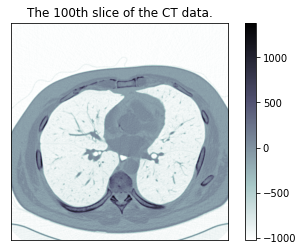

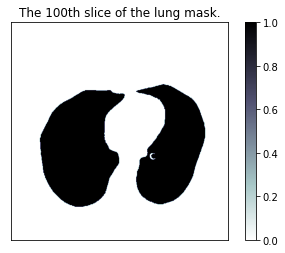

In [4]:
# read in the index th CT data and lung mask
sample_CT_path = stats_dict['lung_image_file_list'][index]
sample_CT_array, lung_mask_array = get_original_data_newversion(stats_dict['lung_image_path'], stats_dict['lung_mask_path'], sample_CT_path)
# show example slices
show_slice(sample_CT_array[depth], title=f"The {depth+1}th slice of the CT data.")
show_slice(lung_mask_array[depth], title=f"The {depth+1}th slice of the lung mask.")

In [5]:
sample_CT_array.shape

(201, 512, 512)

## Prior Probability and Real Class Presentation

2024-01-31 12:09:18.575016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 12:09:19.171284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:9d:00.0, compute capability: 8.0
2024-01-31 12:09:20.429845: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


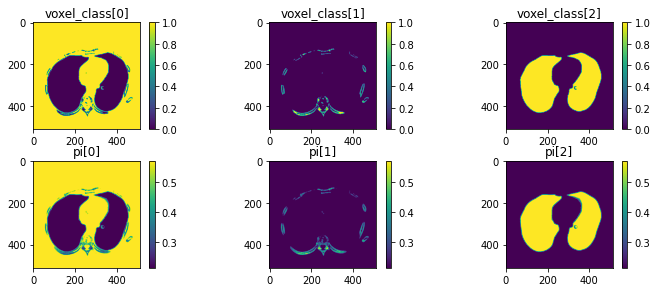

In [5]:
pi, voxel_class = generate_pi_new_version(sample_CT_array, lung_mask_array, bone_threshold=400, IsShow=True)

**🚩Figure 1 (a)-(c)**: the true prior probability functions

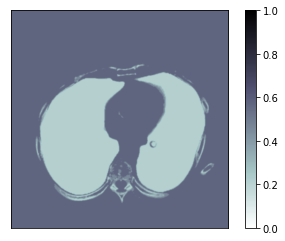

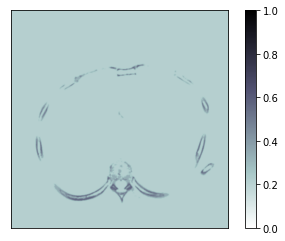

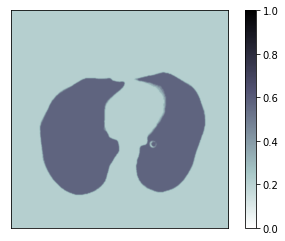

In [6]:
for k in range(3):
    show_slice(pi[k, depth], title=None, Bar=True, OutLines=True, Bar_range=[0, 1])

From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.6211]; Class lung[0.0648]


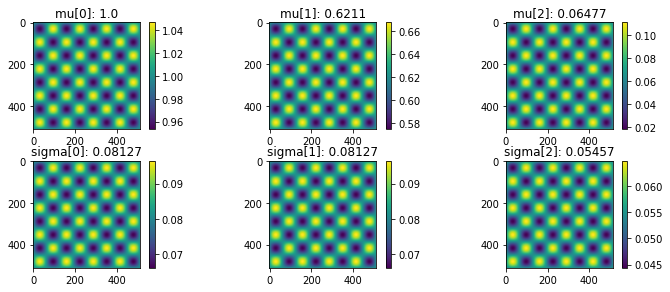

In [7]:
mu, sigma = generate_mu_sigma_new_version(sample_CT_array, voxel_class, IsShow=True)

**🚩Figure (d)-(f)**: the true mean functions

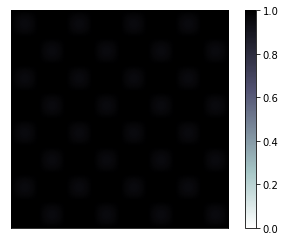

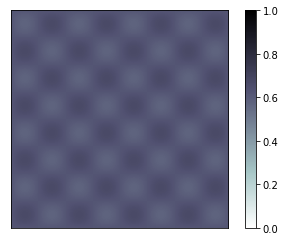

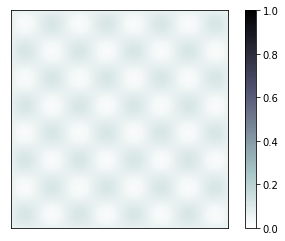

In [8]:
vmin = tf.reduce_min(mu[:, depth])
vmax = tf.reduce_max(mu[:, depth])

for k in range(3):
    show_slice(mu[k, depth], title=None, Bar=True, OutLines=True, Bar_range=[0, 1])

**🚩Figure (g)-(i)**: the true sigma functions

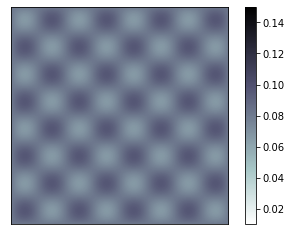

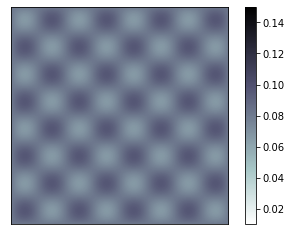

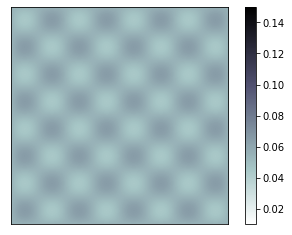

In [9]:
vmin = 0.01
vmax = 0.15

for k in range(3):
    show_slice(sigma[k, depth], title=None, Bar=True, OutLines=True, Bar_range=[vmin, vmax])

# Generate the Simulate Data Based on the Parameters

################ k = 0 ################
[0] tmp_data.max: 1.996
[0] tmp_data.mean: 1.0


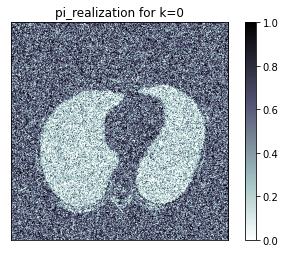

################ k = 1 ################
[1] tmp_data.max: 1.578
[1] tmp_data.mean: 0.6211


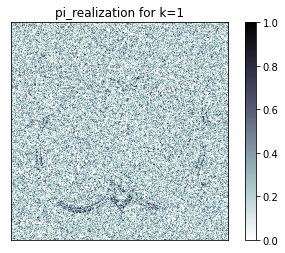

################ k = 2 ################
[2] tmp_data.max: 0.8302
[2] tmp_data.mean: 0.06479


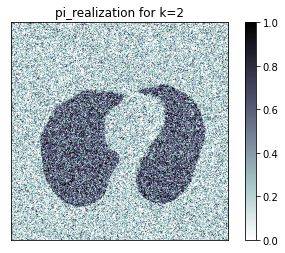

from function(generate_simulate_data_new_version): simulate_data.max=1.913


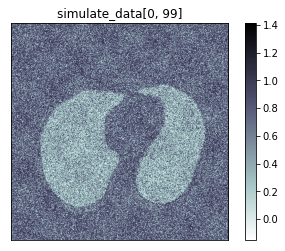

In [10]:
simulate_data, pi_realization = generate_simulate_data_new_version(pi, mu, sigma, seed=0, IsShow=True)

## Training and Testing Data Preparation

In [11]:
np.random.seed(0)
tf.random.set_seed(0)

training_ratio = 1  # ratio of the voxel positions are used for training

# generate a mask, if =1 then are maintained as training data
position_mask = np.random.binomial(n=1, p=training_ratio, size=simulate_data.shape)
position_mask = tf.convert_to_tensor(position_mask, dtype=tf.float32)
training_data = position_mask * simulate_data
# if =0 then are maintained as training data
testing_data = (1 - position_mask) * simulate_data

# KEM Algorithm

In [12]:
Ch_path = "./【results】/Ch-2023-10-31.csv"
Ch_df = pd.read_csv(Ch_path)
Ch = Ch_df.Ch_REG.median()
Ch = round(Ch, 4)
print(f"Ch (Bandwidth Constant): {Ch}")

Ch (Bandwidth Constant): 0.2217


In [13]:
CT_shape = sample_CT_array.shape
CT_shape

(201, 512, 512)

In [14]:
bandwidth, kernel_shape = bandwidth_preparation_small(position_mask, Ch)
print(bandwidth, kernel_shape)

0.017484795338299615 (7, 7, 7)


In [15]:
kem_model = KEM_SIMU_complex(K=3, 
                          shape=sample_CT_array.shape, 
                          training_data=training_data, 
                          position_mask=position_mask, 
                          kernel_shape=kernel_shape, 
                          bandwidth=bandwidth, 
                          kmeans_sample_ratio=1/100/training_ratio,
                          testing_data=testing_data)

From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.009991 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 1.673 seconds
	centers: [1.0047933  0.6124762  0.06041934]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 201, 512, 512, 1)
	pi_estimate: (3, 201, 512, 512, 1)
	mu_estimate: (3, 201, 512, 512, 1)
	sigma_estimate: (3, 201, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (7, 7, 7, 1, 1)


**🚩run KEM algorithm:**

In [16]:
kem_model.kem_algorithm(max_steps=20, epsilon=1e-5, smooth_parameter=1e-20)

From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.218597
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0292501
	 Current mu difference: 0.00465346
	 Current sigma difference: 0.00253706
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: 0.0364406.
---This iteration step costs 6.967 seconds.---
########################## STEP 1 ##########################
	 Current pik difference: 0.00475454
From function(kem_algorithm): E step success.
	 Current pi difference: 0.000296654
	 Current mu difference: 8.81482e-05
	 Current sigma difference: 0.000154028
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: 0.00053883.
---This iteration step costs 2.087 seconds.---
########################## STEP 2 ##########################
	 Current pik difference: 0.0

**🚩the RMSE:**

In [17]:
kem_pi_rmse, kem_mu_rmse, kem_sigma_rmse = compute_RMSE(kem_model, pi, mu, sigma)
kem_pi_rmse, kem_mu_rmse, kem_sigma_rmse

(0.033418305, 0.01926692, 0.008812496)

**🚩graphically show compare $\pi$ true values and estimators:**

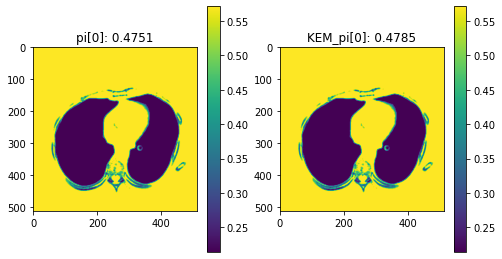

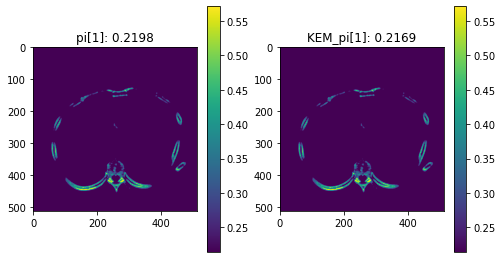

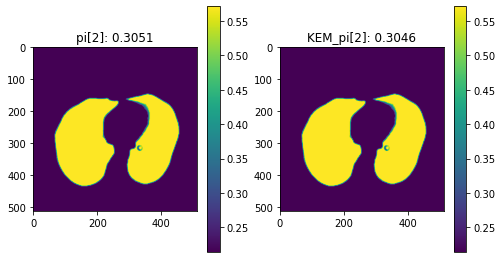

In [25]:
kem_pi_estimate = kem_model.pi_estimate

for k in range(3):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(7)
    fig.tight_layout()
    # show real prior probability
    ax0 = ax[0].imshow(pi[k, 99])
    ax[0].set_title(f"pi[{k}]: {tf.reduce_mean(pi[k, 99]):.4}")
    fig.colorbar(ax0, ax=ax[0])

    # show estimated prior probability
    ax1 = ax[1].imshow(pi[k, 99])
    ax[1].set_title(f"KEM_pi[{k}]: {tf.reduce_mean(kem_pi_estimate[k, 99]):.4}")
    fig.colorbar(ax1, ax=ax[1])

In [26]:
mu_estimate = kem_model.mu_estimate
sigma_estimate = kem_model.sigma_estimate
kem_pik_estimate = kem_model.pik_estimate

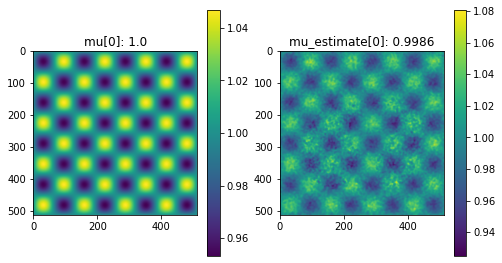

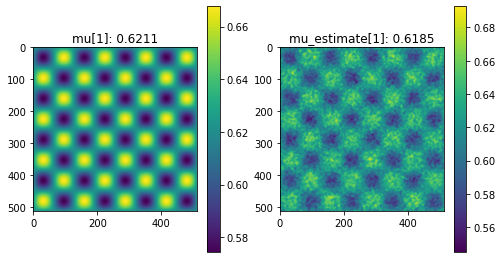

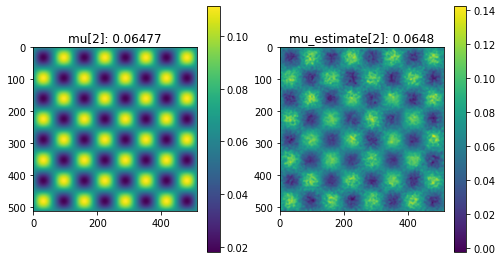

In [27]:
for k in range(3):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(7)
    fig.tight_layout()
    # show real mu
    ax0 = ax[0].imshow(mu[k, 99])
    ax[0].set_title(f"mu[{k}]: {tf.reduce_mean(mu[k, 99]):.4}")
    fig.colorbar(ax0, ax=ax[0])
    # show mu estimate
    ax1 = ax[1].imshow(mu_estimate[k, 99])
    ax[1].set_title(f"mu_estimate[{k}]: {tf.reduce_mean(mu_estimate[k, 99]):.4}")
    fig.colorbar(ax1, ax=ax[1])

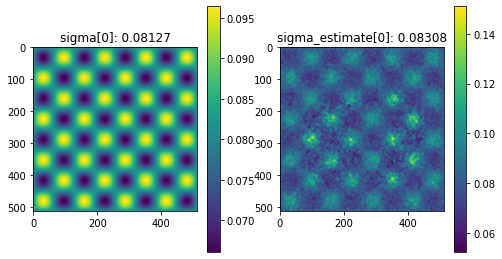

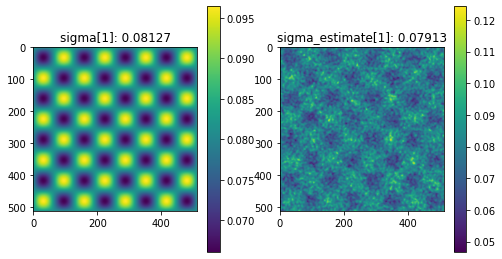

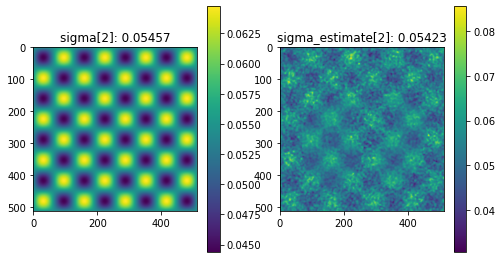

In [28]:
for k in range(3):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(7)
    fig.tight_layout()
    # show real sigma
    ax0 = ax[0].imshow(sigma[k, 99])
    ax[0].set_title(f"sigma[{k}]: {tf.reduce_mean(sigma[k, 99]):.4}")
    fig.colorbar(ax0, ax=ax[0])
    # show sigma estimate
    ax1 = ax[1].imshow(sigma_estimate[k, 99])
    ax[1].set_title(f"sigma_estimate[{k}]: {tf.reduce_mean(sigma_estimate[k, 99]):.4}")
    fig.colorbar(ax1, ax=ax[1])

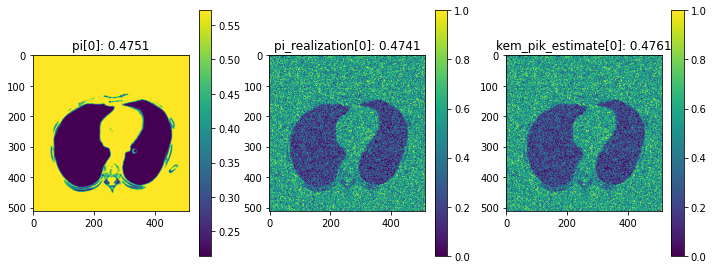

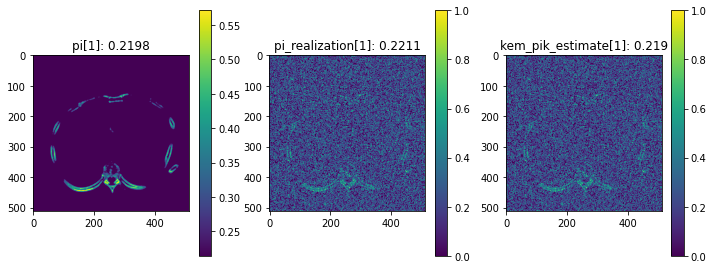

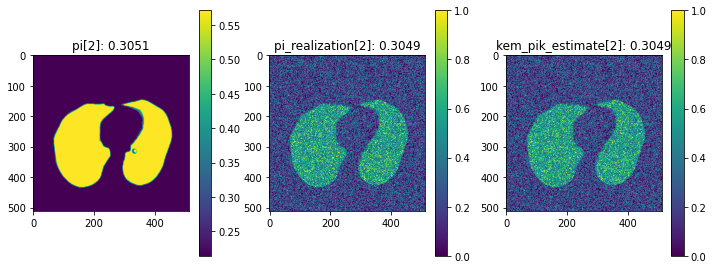

In [29]:
for k in range(3):
    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(10)
    fig.tight_layout()
    # show real prior probability
    ax0 = ax[0].imshow(pi[k, 99])
    ax[0].set_title(f"pi[{k}]: {tf.reduce_mean(pi[k, 99]):.4}")
    fig.colorbar(ax0, ax=ax[0])
    # show pi's realization
    ax1 = ax[1].imshow(pi_realization[k, 99])
    ax[1].set_title(f"pi_realization[{k}]: {tf.reduce_mean(pi_realization[k, 99]):.4}")
    fig.colorbar(ax1, ax=ax[1])
    # show pi estimate
    ax2 = ax[2].imshow(kem_pik_estimate[k, 99])
    ax[2].set_title(f"kem_pik_estimate[{k}]: {tf.reduce_mean(kem_pik_estimate[k, 99]):.4}")
    fig.colorbar(ax2, ax=ax[2])

**🚩Figure 1 (j)-(l)**: the estimated pi functions

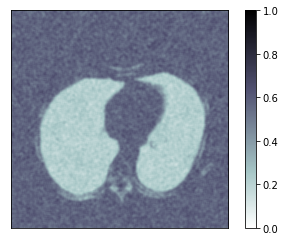

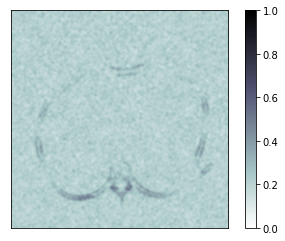

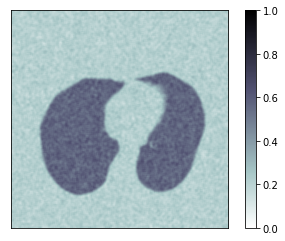

In [30]:
for k in range(3):
    show_slice(kem_pi_estimate[k, depth], title=None, Bar=True, OutLines=True, Bar_range=[0, 1])

**🚩Figure 1 (m)-(o)**: the estimated mean functions

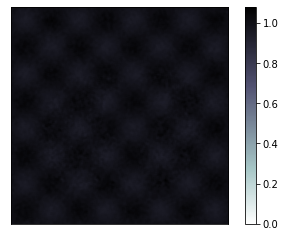

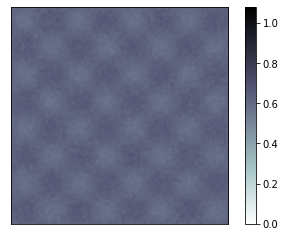

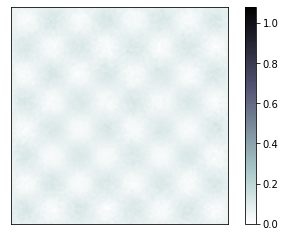

In [31]:
vmin = tf.reduce_min(mu_estimate[:, depth]).numpy()
vmax = tf.reduce_max(mu_estimate[:, depth]).numpy()

for k in range(K):
    show_slice(mu_estimate[k, depth], title=None, Bar=True, OutLines=True, Bar_range=[vmin, vmax])

**🚩Figure 1 (p)-(r)**: the estimated sigma functions

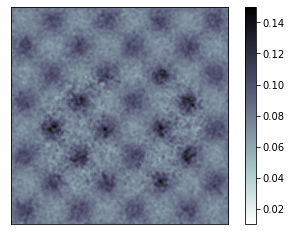

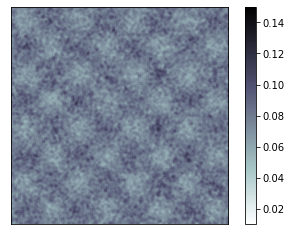

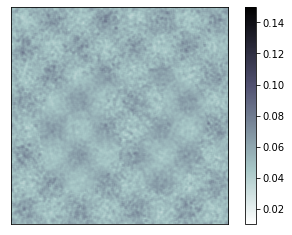

In [32]:
vmin = 0.01
vmax = 0.15

for k in range(K):
    show_slice(sigma_estimate[k, depth], title=None, Bar=True, OutLines=True, Bar_range=[vmin, vmax])

### Different Sampling Ratio for Consistency

In [33]:
np.random.seed(0)
tf.random.set_seed(0)

training_ratio_list = [0.01, 0.1, 0.5, 1.0]
mse_results = []

In [34]:
Ch_path = "./【results】/Ch-2023-10-31.csv"
Ch_df = pd.read_csv(Ch_path)
Ch = Ch_df.Ch_REG.median()
Ch = round(Ch, 4)
print(f"Ch (Bandwidth Constant): {Ch}")

Ch (Bandwidth Constant): 0.2217


In [35]:
for training_ratio in training_ratio_list:
    print("===================================================")
    print(f"------------- training_ratio {training_ratio} -------------")
    position_mask = np.random.binomial(n=1, p=training_ratio, size=simulate_data.shape)
    position_mask = tf.convert_to_tensor(position_mask, dtype=tf.float32)
    training_data = position_mask * simulate_data
    bandwidth, kernel_shape = bandwidth_preparation_small(position_mask, Ch)
    kem_model = KEM_SIMU_complex(K=3, shape=sample_CT_array.shape, 
                              training_data=training_data, 
                              position_mask=position_mask, 
                              kernel_shape=kernel_shape, 
                              bandwidth=bandwidth, 
                              kmeans_sample_ratio=1/100/training_ratio, 
                              testing_data=None)
    kem_model.kem_algorithm(max_steps=50, epsilon=1e-4, smooth_parameter=1e-20)
    pi_rmse, mu_rmse, sigma_rmse = compute_RMSE(kem_model, pi, mu, sigma)
    print(f"\tUltimate MSE: pi_rmse: {pi_rmse:.4}; mu_rmse: {mu_rmse:.4}; sigma_rmse: {sigma_rmse:.4}")
    # record results
    mse_results.append([training_ratio, kernel_shape[0], pi_rmse, mu_rmse, sigma_rmse])

------------- training_ratio 0.01 -------------
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 1.0 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 0.5805 seconds
	centers: [1.0055671  0.61285925 0.06025621]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 201, 512, 512, 1)
	pi_estimate: (3, 201, 512, 512, 1)
	mu_estimate: (3, 201, 512, 512, 1)
	sigma_estimate: (3, 201, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (17, 17, 17, 1, 1)
From function(kem_algorithm): Receive max_steps: 50.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.222186
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0307157
	 Current mu difference: 0.00392214
	 Current sigma difference: 0.00246435
From function(kem_algorithm): M step success.
From fu

In [36]:
mse_results_DF = pd.DataFrame(mse_results, columns=['ratio', "kernel_size", "pi_rmse", "mu_rmse", "sigma_rmse"])
CT_shape = sample_CT_array.shape
N = CT_shape[0] * CT_shape[1] * CT_shape[2]
mse_results_DF['b_pi'] = mse_results_DF['pi_rmse'] * ((mse_results_DF['ratio'] * N)**(2 / 7))
mse_results_DF['b_mu'] = mse_results_DF['mu_rmse'] * ((mse_results_DF['ratio'] * N)**(2 / 7))
mse_results_DF['b_sigma'] = mse_results_DF['sigma_rmse'] * ((mse_results_DF['ratio'] * N)**(2 / 7))
mse_results_DF

,ratio,kernel_size,pi_rmse,mu_rmse,sigma_rmse,b_pi,b_mu,b_sigma
0,0.01,17,0.074307,0.042869,0.022292,3.204869,1.848951,0.961473
1,0.10,11,0.048641,0.026524,0.012178,4.050419,2.208696,1.014111
2,0.50,9,0.035067,0.021009,0.008872,4.624921,2.770829,1.170062
3,1.00,7,0.033712,0.020208,0.009272,5.419999,3.248889,1.490707
